## 1. Data Import

In [1]:
%pip install pyarrow
%pip install ipywidgets
%pip install ipympl
%pip install tqdm
%matplotlib widget


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from tqdm import tqdm

## 2. Plot erstellen

In [3]:
df_file = pd.read_parquet("../MGFarm_18650_Dataframes/MGFarm_18650_C13/df.parquet")
df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] = pd.to_datetime(df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])


In [4]:
# Data filter
start_id_selector = widgets.Dropdown(
    options=sorted(df_file['Schedule_Step_ID'].unique()),
    description='Start ID:',
    disabled=False,
)
end_id_selector = widgets.Dropdown(
    options=sorted(df_file['Schedule_Step_ID'].unique()),
    description='End ID:',
    disabled=False,
)

# Data filter for start and end -- Time
min_time = df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'].min()
max_time = df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'].max()

start_time_selector = widgets.Dropdown(
    options=pd.date_range(min_time, max_time, freq='D').strftime('%Y-%m-%d %H:%M:%S'),
    description='Start Time:',
    disabled=False,
)
end_time_selector = widgets.Dropdown(
    options=pd.date_range(min_time, max_time, freq='D').strftime('%Y-%m-%d %H:%M:%S'),
    description='End Time:',
    disabled=False,
)

# Plot function
def plot(start_id, end_id, start_time, end_time):
    # According to ID
    filtered_data = df_file[(df_file['Schedule_Step_ID'] >= start_id) & 
                            (df_file['Schedule_Step_ID'] <= end_id)]
    # According to Time
    if start_time:
        filtered_data = filtered_data[filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] >= pd.Timestamp(start_time)]
    if end_time:
        filtered_data = filtered_data[filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] <= pd.Timestamp(end_time)]
    
    # First Plot -- Voltage and Schedule Step ID
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.set_xlabel('Absolute Time')
    ax1.set_ylabel('Voltage[V]')
    ax1.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['Voltage[V]'], color='blue', label='Voltage[V]')
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Schedule_Step_ID')
    ax2.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['Schedule_Step_ID'], color='green', label='Schedule_Step_ID', linestyle='--')
    ax2.legend(loc='upper right')
    
    plt.title(f'Voltage and Schedule Step ID over Time (From ID {start_id} to {end_id})')
    plt.tight_layout()
    plt.show()

    # Second Plot -- Current
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Absolute Time')
    ax3.set_ylabel('Current[A]')
    ax3.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['Current[A]'], color='blue', label='Current[A]')
    ax3.legend(loc='upper left')

    ax4 = ax3.twinx()
    ax4.set_ylabel('Schedule_Step_ID')
    ax4.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['Schedule_Step_ID'], color='green', label='Schedule_Step_ID', linestyle='--')
    ax4.legend(loc='upper right')
    
    plt.title(f'Current over Time (From ID {start_id} to {end_id})')
    plt.tight_layout()
    plt.show()

# Widgets Interaction
widgets.interact(plot, start_id=start_id_selector, end_id=end_id_selector, start_time=start_time_selector, end_time=end_time_selector)

interactive(children=(Dropdown(description='Start ID:', options=(1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, …

<function __main__.plot(start_id, end_id, start_time, end_time)>

## SOH SOC calculation
1. SOH 
- Start ID 1 End ID 7
- Compte original Capacity using fully discharge time

    $Capacity(Ah)=∫_{t0}^{t1}I(t)t$

- Compute current Capacity
- Compute SOH

    $ SOH = \frac{C_{\text{current}}}{C_{\text{initial}}}$

2. SOC
- Find the start of SOC(0) = 1
- Compute SOC
 
    $SOC(t) = SOC(0) + \frac{1}{C_{nom}} \int_0^t I(t)dt *100$ 

In [5]:
# Set start and end time
start_time = df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'].min()
end_time = df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'].max()

filtered_data = df_file[
    (df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] >= start_time) &
    (df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] <= end_time)
]

# dt 
filtered_data['Time_diff'] = filtered_data['Testtime[s]'].diff() / 3600
filtered_data.loc[filtered_data['Time_diff'].abs() > 0.5, 'Time_diff'] = 0
filtered_data.fillna({'Time_diff':0}, inplace=True)

# Parameter initialize SOH
C_initial = None
C_current = 0
soh_values = []

# Parameter initialize SOC
C_nom = None
filtered_data['SOC_ZHU'] = np.nan
soc_start = filtered_data.loc[filtered_data['Schedule_Step_ID'] == 5,'Absolute_Time[yyyy-mm-dd hh:mm:ss]'].iloc[0]
soc_init = 1
soc_values = []
soc_t0 = soc_init
V_max = filtered_data['Voltage[V]'].max() 
V_min = filtered_data['Voltage[V]'].min() 

# Compute SOH during fully discharge state [5,8)
for idx, row in tqdm(filtered_data.iterrows(), total=len(filtered_data), desc="Processing data"):
    # Calculate SOH
    # Fully discharge phase
    if row['Schedule_Step_ID'] in range(5, 8):  
        C_current += row['Current[A]'] * row['Time_diff']
        
    elif C_current != 0:
        #Set first fully discharge state as Initial
        if C_initial is None: 
            C_initial = C_current     
            C_nom = abs(C_initial)    
        # Calculate SOH after fully discharge
        soh_values.append((idx, C_current / C_initial))
        C_current = 0
     
    if row['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] >= soc_start and C_nom:
    # Calculate SOC
        delta_soc = (row['Current[A]'] * row['Time_diff']) / C_nom 
        soc_t = soc_t0 + delta_soc
        # Reset SOC after CV phase from every Capacity test 
        if row['Schedule_Step_ID'] == 5:
            soc_t = 1.0  # Fully charged during CV phase
        elif row['Voltage[V]'] >= V_max:
            soc_t = 1.0  # SOC at 1.0 if voltage is at maximum
        elif row['Voltage[V]'] <= V_min:
            soc_t = 0.0  # SOC if voltage is at minimum

        soc_t = max(0.0, min(soc_t, 1.0))
        soc_values.append((idx, soc_t))
        soc_t0 = soc_t 

print(f"Original capacity: {abs(C_initial)} Ah") 

for idx, soh_value in tqdm(soh_values, total=len(soh_values), desc="Updating SOH"):
    filtered_data.loc[idx, 'SOH_ZHU'] = soh_value
    
filtered_data['SOH_ZHU'] = filtered_data['SOH_ZHU'].interpolate(method='linear')    

for idx, soc_value in tqdm(soc_values, total=len(soc_values), desc="Updating SOC"):
    filtered_data.loc[idx, 'SOC_ZHU'] = soc_value

filtered_data.to_parquet('df_09.parquet',index = False)
filtered_data

Processing data: 100%|██████████| 9138815/9138815 [12:08<00:00, 12538.58it/s]


Original capacity: 1.7941929138888915 Ah


Updating SOC: 100%|██████████| 8868593/8868593 [24:17<00:00, 6086.25it/s]


,Absolute_Time[yyyy-mm-dd hh:mm:ss],Testtime[s],Step_ID,Schedule_Step_ID,Step_Time[s],Voltage[V],Current[A],Temperature[°C],Aux_U[V],Aux_I[A],...,Q_sum,Capacity[Ah],SOH,Q_c,EFC,SOC_c,SOC_m,Time_diff,SOC_ZHU,SOH_ZHU
159888,2023-02-02 09:06:28,161519.3,592,52,0.0,3.4136,1.7994,26.1,-0.0004,NaN,...,10.301186,1.791737,1.000778,-0.575838,5.753747,0.678364,0.672740,0.000000,NaN,NaN
159889,2023-02-02 09:06:29,161520.3,592,52,1.0,3.4303,1.7991,25.9,-0.0004,NaN,...,10.301686,1.791737,1.000778,-0.575339,5.754027,0.678644,0.673019,0.000278,NaN,NaN
159890,2023-02-02 09:06:30,161521.3,592,52,2.0,3.4424,1.7987,25.9,-0.0006,NaN,...,10.302186,1.791737,1.000778,-0.574839,5.754306,0.678923,0.673298,0.000278,NaN,NaN
159891,2023-02-02 09:06:31,161522.3,592,52,3.0,3.4511,1.7987,25.9,-0.0004,NaN,...,10.302685,1.791737,1.000778,-0.574339,5.754585,0.679202,0.673577,0.000278,NaN,NaN
159892,2023-02-02 09:06:32,161523.3,592,52,4.0,3.4582,1.7991,25.9,-0.0006,NaN,...,10.303185,1.791737,1.000778,-0.573839,5.754864,0.679481,0.673856,0.000278,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9298698,2023-05-23 08:09:29,9291475.9,850,61,896.0,3.2291,0.0000,26.0,-0.0004,NaN,...,3067.011010,1.222744,0.682966,-0.672037,1713.084924,0.624632,-2.093439,0.000278,0.459559,0.681501
9298699,2023-05-23 08:09:30,9291476.9,850,61,897.0,3.2294,0.0000,26.2,-0.0004,NaN,...,3067.011010,1.222744,0.682966,-0.672037,1713.084924,0.624632,-2.093439,0.000278,0.459559,0.681501
9298700,2023-05-23 08:09:31,9291477.9,850,61,898.0,3.2294,0.0000,26.2,-0.0004,NaN,...,3067.011010,1.222744,0.682966,-0.672037,1713.084924,0.624632,-2.093439,0.000278,0.459559,0.681501
9298701,2023-05-23 08:09:32,9291478.9,850,61,899.0,3.2294,0.0000,26.2,-0.0004,NaN,...,3067.011010,1.222744,0.682966,-0.672037,1713.084924,0.624632,-2.093439,0.000278,0.459559,0.681501


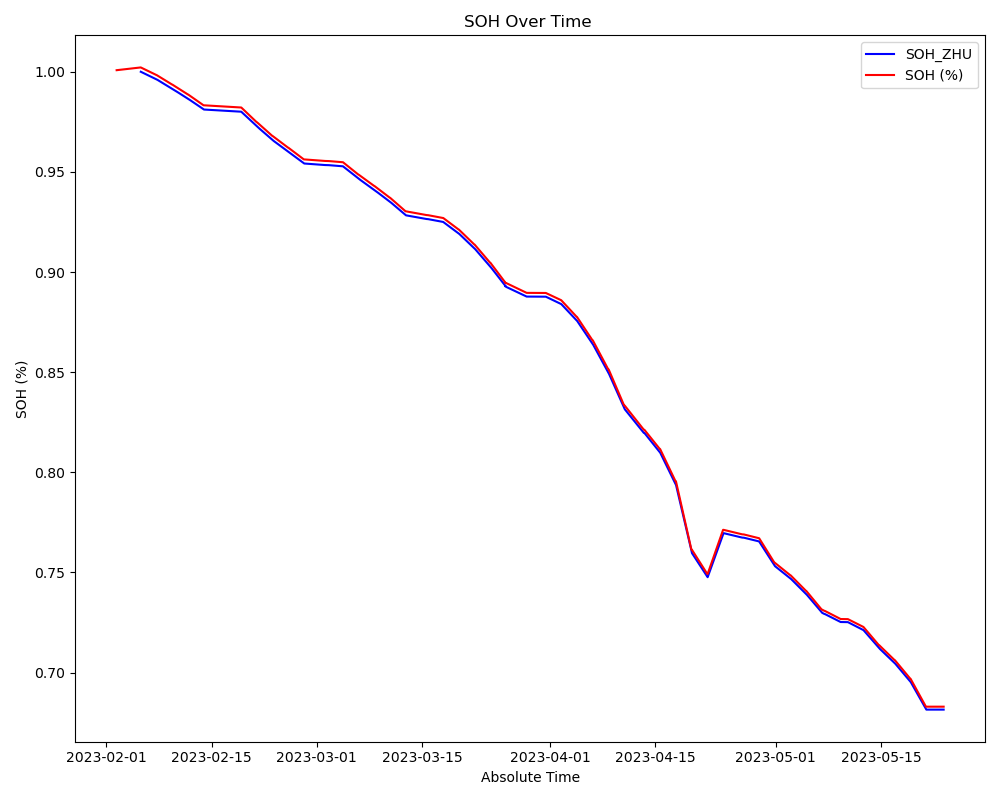

In [6]:
plt.figure(figsize=(10, 8))
plt.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['SOH_ZHU'], linestyle='-', color='blue', label='SOH_ZHU')
plt.plot(df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], df_file['SOH'], label='SOH (%)', color='red')
plt.xlabel('Absolute Time')
plt.ylabel('SOH (%)')
plt.title('SOH Over Time ')
plt.legend(loc="best")
plt.tight_layout()
plt.show()


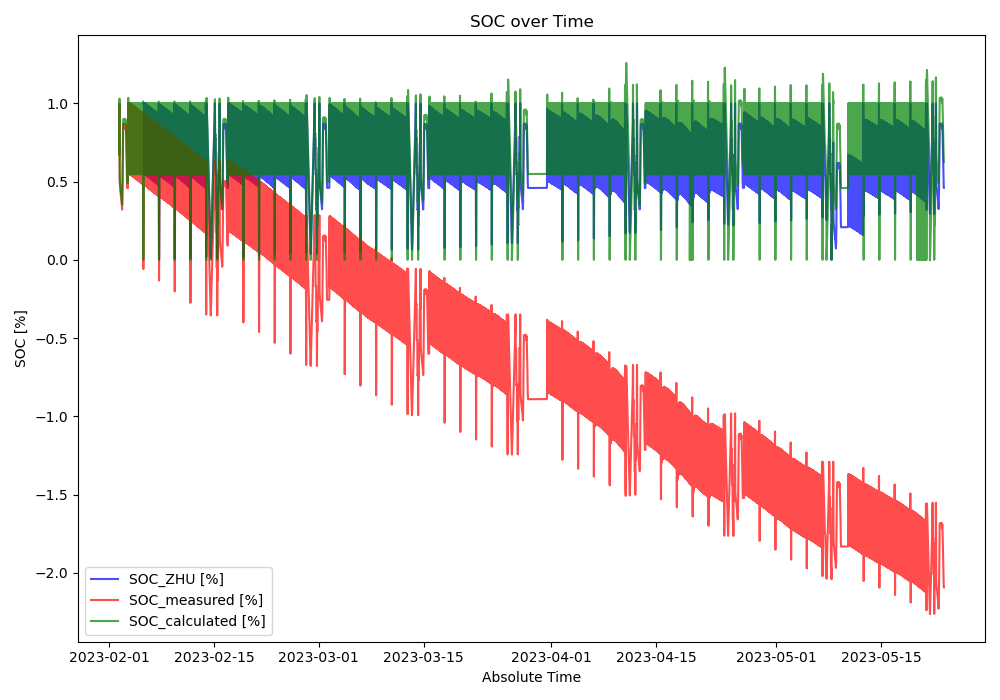

In [7]:
plt.figure(figsize=(10, 7))
plt.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['SOC_ZHU'], label='SOC_ZHU [%]', color='blue', alpha=0.7)
plt.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['SOC_m'], label='SOC_measured [%]', color='red', alpha=0.7)
plt.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['SOC_c'], label='SOC_calculated [%]', color='green', alpha=0.7)
plt.xlabel('Absolute Time')
plt.ylabel('SOC [%]')
plt.title('SOC over Time')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
# # Find fully discharge time -- from 02.06
# filtered_data = df_file[
#     (df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] > '2023-02-04 00:00:00') & 
#     (df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] <= '2023-02-07 00:00:00') & 
#     (df_file['Schedule_Step_ID'] >= 5) & 
#     (df_file['Schedule_Step_ID'] <= 7)
# ]

# # compute dt
# filtered_data['Time_diff'] = filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'].diff().dt.total_seconds() / 3600

# # Compute I*dt
# filtered_data['Discharge'] = filtered_data['Current[A]'] * filtered_data['Time_diff']

# # Compute sum
# Capacity_Initial = filtered_data['Discharge'].sum()

# # Fully discharge capacity
# print(f"Original capacity: {abs(Capacity_Initial)} Ah")



In [ ]:
# df_soc = pd.read_parquet("Output/df_C01.parquet")
# # df_soc = df_soc[['Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'Schedule_Step_ID', 
# #                   'Voltage[V]', 'Current[A]', 'Capacity[Ah]', 'SOH', 'SOC_c', 'SOC_m','SOH_ZHU'
# #            ]]
# # df_soc['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] = pd.to_datetime(df_soc['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
# df_soc = df_soc.iloc[:, :-1]
# df_soc

In [ ]:
# # start_time = '2023-02-04 00:00:00'
# # end_time = '2023-02-07 00:00:00'
# time_soc = df_soc

# # Find the first fully charge time point
# soc_start = time_soc.loc[time_soc['Schedule_Step_ID'] == 5,'Absolute_Time[yyyy-mm-dd hh:mm:ss]'].iloc[0]
# print(f"SOC test start from: {soc_start}")

In [ ]:
# # Set first fully charge time as SOC(0)
# soc_end = df_soc['Absolute_Time[yyyy-mm-dd hh:mm:ss]'].max()
# # soc_end = '2023-02-10 03:00:00'
# soc_data = df_soc[
#     (df_soc['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] >= soc_start) &
#     (df_soc['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] <= soc_end) 
# ]

# # dt
# soc_data['Time_diff'] = soc_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'].diff().dt.total_seconds() / 3600
# soc_data['Time_diff'].fillna(0, inplace=True)

# # Initalize
# # Capacity_Initial =  1.7806211666666667  #C15
# Capacity_Initial = 1.7841511111111115 #C01
# c_nom = Capacity_Initial
# soc_init = 1
# soc = []
# soc1 = []
# soc_t0 = soc_init
# soc_t01 = soc_init
# V_max = soc_data['Voltage[V]'].max() 
# V_min = soc_data['Voltage[V]'].min() 

# # compute soc
# for _, row in tqdm(soc_data.iterrows(), total=len(soc_data), desc="Processing SOC"):
#     delta_soc = (row['Current[A]'] * row['Time_diff']) / c_nom 
#     soc_t = soc_t0 + delta_soc
#     soc_t1 = soc_t01 + delta_soc
    
    
#     if row['Schedule_Step_ID'] == 5:
#         soc_t = 1.0
#     if row['Schedule_Step_ID'] == 12:
#         soc_t1 = 1.0
        
#     if row['Voltage[V]'] >= V_max:
#         soc_t = 1.0
#         soc_t1 = 1.0
#     elif row['Voltage[V]'] <= V_min:
#         soc_t = 0.0
#         soc_t1 = 0.0

#     soc_t = max(0.0, min(soc_t, 1.0))
#     soc.append(soc_t)
#     soc_t0 = soc_t 

#     soc_t1 = max(0.0, min(soc_t1, 1.0))
#     soc1.append(soc_t1)
#     soc_t01 = soc_t 

# soc_data['SOC_0'] = soc
# soc_data['SOC_1'] = soc1


In [ ]:
# df = df_soc.merge(
#     soc_data[['Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'SOC_ZHU']],
#     on='Absolute_Time[yyyy-mm-dd hh:mm:ss]',
#     how='left'  
# )


In [ ]:
# soc_data.to_parquet(f"df_C01.parquet", index = False)
# df

In [ ]:
# plt.figure(figsize=(14, 7))
# plt.plot(soc_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], soc_data['SOC_0'], label='SOC_0 [%]', color='blue', alpha=0.7)
# plt.plot(soc_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], soc_data['SOC_1'], label='SOC_1 [%]', color='yellow', alpha=0.7)
# # plt.plot(soc_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], soc_data['SOC_m'], label='SOC_measured [%]', color='red', alpha=0.7)
# # plt.plot(soc_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], soc_data['SOC_c'], label='SOC_calculated [%]', color='green', alpha=0.7)
# plt.xlabel('Absolute Time')
# plt.ylabel('SOC [%]')
# plt.title('SOC over Time')
# plt.legend()
# plt.tight_layout()
# plt.show()